In [3]:
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
print(torch.cuda.get_device_name())
import math
import struct
import csv
import time

from utils_voxelmorph_plusplus import *



H = 192; W = 192; D = 208

class ConvBlock(nn.Module):
    """
    Specific convolutional block followed by leakyrelu for unet.
    """

    def __init__(self, ndims, in_channels, out_channels, stride=1):
        super().__init__()

        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.main = Conv(in_channels, out_channels, 3, stride, 1)
        self.norm = nn.InstanceNorm3d(out_channels)
        self.activation = nn.ReLU()#nn.LeakyReLU(0.2)
        self.main2 = Conv(out_channels, out_channels, 1, stride,0)
        self.norm2 = nn.InstanceNorm3d(out_channels)
        self.activation2 = nn.ReLU()#nn.LeakyReLU(0.2)


    def forward(self, x):
        out = self.activation(self.norm(self.main(x)))
        out = self.activation2(self.norm2(self.main2(out)))
        return out

inshape = (224//2,224//2,224//2)
unet_half_res=True
nb_unet_features=None; nb_unet_levels=None
unet_feat_mult=1; nb_unet_conv_per_level=1; int_steps=7; int_downsize=2
bidir=False; use_probs=False; src_feats=1; trg_feats=1; unet_half_res=False; unet_half_res=True

def default_unet_features():
    nb_features = [[32, 48, 48, 64], [64, 48, 48, 48, 48, 32, 64]]  #  encoder,decoder
    return nb_features


def evaluate(unet_model,heatmap,ii):
    gpu_usage()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            
            mind_fix = mind_all_fix[ii].cuda().half()
            mind_mov = mind_all_mov[ii].cuda().half()
            
            keypts_fix = keypts_all_fix[int(ii)].cuda()
            keypts_mov = keypts_all_mov[int(ii)].cuda()

            disp_gt = keypts_mov-keypts_fix
            
            input = F.pad(torch.cat((mind_fix,mind_mov),1),(4,4,8,8,8,8)).cuda()
            output = unet_model(input)[:,:,4:-4,4:-4,2:-2]

            idx = torch.arange(keypts_all_fix[int(ii)].shape[0])
            sample_xyz = keypts_all_fix[int(ii)][idx]
            sampled = F.grid_sample(output,sample_xyz.cuda().view(1,-1,1,1,3),mode='bilinear')
            #sampled = F.grid_sample(output,sample_xyz.cuda().view(1,-1,1,1,3)+patch.view(1,1,-1,1,3),mode='bilinear')
            disp_pred = heatmap(sampled.permute(2,1,0,3,4))
#            disp_pred = heatmap(sampled.permute(2,1,0,3,4).view(keypts_fix.shape[0],-1,3,3,3))

            pred_xyz = torch.sum(torch.softmax(disp_pred.view(-1,11**3,1),1)*mesh.view(1,11**3,3),1)

    #plt.plot(pred_xyz[:,2].data.cpu(),disp_gt[:,2].data.cpu(),'.')
    tre0 = disp_gt.mul(100).pow(2).sum(1).sqrt().mean().item()
    tre1 = (disp_gt-pred_xyz).mul(100).pow(2).sum(1).sqrt().mean().item()
    return tre0,tre1,pred_xyz



NVIDIA RTX A4000


In [4]:
#discretised heatmap grid (you may have to adapt the capture range from .3)
mesh = F.affine_grid(torch.eye(3,4).unsqueeze(0).cuda()*.3,(1,1,11,11,11)).half()

patch = F.affine_grid(0.05*torch.eye(3,4).unsqueeze(0).cuda().half(),(1,1,3,3,3))


H = W = 192; D = 208
nomind = False
keypts_all_mov,keypts_all_fix,mind_all_mov,mind_all_fix,img_all_mov,img_all_fix,mask_all_mov,mask_all_fix = get_datasets(nomind)

mind_all_mov2 = mind_all_mov.clone().detach()
mind_all_fix2 = mind_all_fix.clone().detach()
#mind_all_mov2 are 12-channel MIND-SSC features used for instance optimisation

nomind = True
keypts_all_mov,keypts_all_fix,mind_all_mov,mind_all_fix,img_all_mov,img_all_fix,mask_all_mov,mask_all_fix = get_datasets(nomind)
#mind_all_mov are simply CT intensities

unet_model = Unet(ConvBlock,inshape,infeats=2,nb_features=nb_unet_features,nb_levels=nb_unet_levels,\
        feat_mult=unet_feat_mult,nb_conv_per_level=nb_unet_conv_per_level,half_res=unet_half_res,)
unet_model.cuda()



heatmap = nn.Sequential(nn.ConvTranspose3d(64,16,7),nn.InstanceNorm3d(16),nn.ReLU(),\
                        nn.Conv3d(16,32,3,padding=1),nn.InstanceNorm3d(32),\
                        nn.ReLU(),nn.Conv3d(32,32,3,padding=1),nn.Upsample(size=(11,11,11),mode='trilinear'),\
                        nn.Conv3d(32,32,3,padding=1),nn.InstanceNorm3d(64),nn.ReLU(),                
                        nn.Conv3d(32,32,3,padding=1),nn.InstanceNorm3d(32),nn.ReLU(),\
                        nn.Conv3d(32,16,3,padding=1),nn.InstanceNorm3d(16),nn.ReLU(),nn.Conv3d(16,1,3,padding=1))
heatmap.cuda()

grid_sp = 2




/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


mind computation 0.08308485349019369 sec
mind computation 0.0057358821233113606 sec


In [8]:
tre_net = torch.zeros(3,30)
disp_copd = torch.zeros(10,3,192,192,208)
for f in range(1,6):

    if(f==1):
        idx_test = torch.tensor([5,7,15,17,18,20])
    if(f==2):
        idx_test = torch.tensor([4,6,14,16,19,21])
    if(f==3):
        idx_test = torch.tensor([3,11,13,22,24,26])
    if(f==4):
        idx_test = torch.tensor([0,2,8,10,23,25])
    if(f==5):
        idx_test = torch.tensor([1,9,12,27,28,29])


    in_channel = 2
    unet_model = Unet(ConvBlock,inshape,infeats=in_channel,nb_features=nb_unet_features,nb_levels=nb_unet_levels,\
                feat_mult=unet_feat_mult,nb_conv_per_level=nb_unet_conv_per_level,half_res=unet_half_res,)
    heatmap = nn.Sequential(nn.ConvTranspose3d(64,16,7),nn.InstanceNorm3d(16),nn.ReLU(),nn.Conv3d(16,32,3,padding=1),nn.InstanceNorm3d(32),nn.ReLU(),                       nn.Conv3d(32,32,3,padding=1),nn.Upsample(size=(11,11,11),mode='trilinear'),nn.Conv3d(32,32,3,padding=1),nn.InstanceNorm3d(64),nn.ReLU(),                        #nn.Conv3d(32,32,3,padding=1),nn.InstanceNorm3d(32),nn.ReLU(),\
                           nn.Conv3d(32,32,3,padding=1),nn.InstanceNorm3d(32),nn.ReLU(),nn.Conv3d(32,16,3,padding=1),nn.InstanceNorm3d(16),nn.ReLU(),nn.Conv3d(16,1,3,padding=1))


    models = torch.load('l2r_lung_ct/repeat_l2r_voxelmorph_heatmap_keypoint_fold'+str(f)+'.pth')
    heatmap.load_state_dict(models['heatmap'])
    unet_model.load_state_dict(models['unet_model'])
    unet_model.cuda(); heatmap.cuda()



    t_inf = 0
    for i,ii in enumerate(idx_test):
        ii = torch.arange(ii,ii+1).long()
        #ii = torch.arange(ii,ii+1).long()
        torch.cuda.synchronize()
        t0 = time.time()
        
        tre0,tre1,pred_xyz = evaluate(unet_model,heatmap,ii)


    

        t_inf += time.time()-t0
        print('tre1 (net)',tre1)
        tre_net[1,int(ii)] = tre1

        keypts_fix = keypts_all_fix[int(ii)].cuda()
        keypts_mov = keypts_all_mov[int(ii)].cuda()

        dense_flow_ = thin_plate_dense(keypts_fix.unsqueeze(0), pred_xyz.unsqueeze(0), (H, W, D), 4, 0.1)
        dense_flow = dense_flow_.flip(4).permute(0,4,1,2,3)*torch.tensor([H-1,W-1,D-1]).cuda().view(1,3,1,1,1)/2


        disp_hr = dense_flow#F.interpolate(dense_flow,size=(H,W,D),mode='trilinear',align_corners=False)
            
        #keypts_fix = keypts_all_fix[int(ii)].cuda()
        #keypts_mov = keypts_all_mov[int(ii)].cuda()

        #disp_gt = pred_xyz#keypts_mov-keypts_fix
        if(True):
            grid_sp = 2

            mind_fix = mind_all_fix2[ii].cuda().half()
            mind_mov = mind_all_mov2[ii].cuda().half()

            disp_lr = F.interpolate(disp_hr,size=(H//grid_sp,W//grid_sp,D//grid_sp),mode='trilinear',align_corners=False)
            net = nn.Sequential(nn.Conv3d(3,1,(H//grid_sp,W//grid_sp,D//grid_sp),bias=False))
            net[0].weight.data[:] = disp_lr.float().cpu().data/grid_sp
            net.cuda()
            optimizer = torch.optim.Adam(net.parameters(), lr=1)
            grid0 = F.affine_grid(torch.eye(3,4).unsqueeze(0).cuda(),(1,1,H//grid_sp,W//grid_sp,D//grid_sp),align_corners=False)
            #run Adam optimisation with diffusion regularisation and B-spline smoothing
            lambda_weight = .65# with tps: .5, without:0.7
            for iter in range(50):#80
                optimizer.zero_grad()
                disp_sample = F.avg_pool3d(F.avg_pool3d(F.avg_pool3d(net[0].weight,3,stride=1,padding=1),3,stride=1,padding=1),3,stride=1,padding=1).permute(0,2,3,4,1)
                reg_loss = lambda_weight*((disp_sample[0,:,1:,:]-disp_sample[0,:,:-1,:])**2).mean()+\
                lambda_weight*((disp_sample[0,1:,:,:]-disp_sample[0,:-1,:,:])**2).mean()+\
                lambda_weight*((disp_sample[0,:,:,1:]-disp_sample[0,:,:,:-1])**2).mean()
                scale = torch.tensor([(H//grid_sp-1)/2,(W//grid_sp-1)/2,(D//grid_sp-1)/2]).cuda().unsqueeze(0)
                grid_disp = grid0.view(-1,3).cuda().float()+((disp_sample.view(-1,3))/scale).flip(1).float()
                patch_mov_sampled = F.grid_sample(mind_mov.float(),grid_disp.view(1,H//grid_sp,W//grid_sp,D//grid_sp,3).cuda(),align_corners=False,mode='bilinear')#,padding_mode='border')
                sampled_cost = (patch_mov_sampled-mind_fix).pow(2).mean(1)*12
                loss = sampled_cost.mean()
                (loss+reg_loss).backward()
                optimizer.step()
            fitted_grid = disp_sample.permute(0,4,1,2,3).detach()
            disp_hr = F.interpolate(fitted_grid*grid_sp,size=(H,W,D),mode='trilinear',align_corners=False)

        disp_smooth = F.avg_pool3d(F.avg_pool3d(F.avg_pool3d(disp_hr,3,padding=1,stride=1),3,padding=1,stride=1),3,padding=1,stride=1)


        disp_hr = torch.flip(disp_smooth/torch.tensor([H-1,W-1,D-1]).view(1,3,1,1,1).cuda()*2,[1])
        if((ii>=8)&(ii<18)):
            disp_copd[ii-8] = disp_hr.cpu()
        if(ii==0):
            disp_hr0 = disp_hr.cpu().clone()
        keypts_fix = keypts_all_fix[ii].cuda()
        keypts_mov = keypts_all_mov[ii].cuda()

        pred_xyz = F.grid_sample(disp_hr.float(),keypts_fix.cuda().view(1,-1,1,1,3),mode='bilinear').squeeze().t()

        disp_gt = keypts_mov-keypts_fix

        tre0 = disp_gt.mul(100).pow(2).sum(1).sqrt().mean().item()
        tre1 = (disp_gt-pred_xyz).mul(100).pow(2).sum(1).sqrt().mean().item()
        print('tre0',tre0,'tre1',tre1)
        tre_net[0,int(ii)] = tre0
        tre_net[2,int(ii)] = tre1
    print('t_inf/avg',t_inf/len(idx_test),'sec')



gpu usage (current/max): 0.01 / 1.97 GB


/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


tre1 (net) 5.672276496887207


/home/jupyter-mattiasheinrich/utils_voxelmorph_plusplus.py:293: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  theta = torch.solve(v, A)[0]


tre0 10.251587867736816 tre1 2.0157971382141113
gpu usage (current/max): 0.56 / 1.97 GB
tre1 (net) 5.119217872619629
tre0 10.415358543395996 tre1 2.1842713356018066
gpu usage (current/max): 0.56 / 1.97 GB
tre1 (net) 3.4058380126953125
tre0 11.494260787963867 tre1 1.5971386432647705
gpu usage (current/max): 0.57 / 1.97 GB
tre1 (net) 4.833573818206787
tre0 10.833680152893066 tre1 2.3015024662017822
gpu usage (current/max): 0.56 / 1.97 GB
tre1 (net) 9.065375328063965
tre0 15.127666473388672 tre1 5.0272111892700195
gpu usage (current/max): 0.56 / 1.97 GB
tre1 (net) 6.875973224639893
tre0 6.011701583862305 tre1 2.5982422828674316
t_inf/avg 0.5127787192662557 sec
gpu usage (current/max): 0.57 / 1.97 GB
tre1 (net) 4.211272716522217
tre0 12.288272857666016 tre1 1.527590036392212
gpu usage (current/max): 0.56 / 1.97 GB
tre1 (net) 5.19342041015625
tre0 13.808403968811035 tre1 2.2900168895721436
gpu usage (current/max): 0.56 / 1.97 GB
tre1 (net) 2.9840354919433594
tre0 5.984557628631592 tre1 0.91

In [9]:
print(tre_net[2],tre_net.mean(1),tre_net[:,8:18].mean(1))


copd_lms = torch.load('copd_converted_lms.pth')
print(copd_lms['lm_copd_insp'].shape)
tre_before = torch.zeros(10,300)
tre_after = torch.zeros(10,300)

for i in range(10):
    disp = F.grid_sample(disp_copd[i:i+1],copd_lms['lm_copd_exh'][i].view(1,-1,1,1,3)).squeeze().t()
    #print((copd_lms['lm_copd_exh_pix'][i]-copd_lms['lm_copd_insp_pix'][i]).pow(2).sum(1).sqrt().mean())
    tre_before[i]=((copd_lms['lm_copd_exh'][i]-copd_lms['lm_copd_insp'][i])*(torch.tensor([208/2,192/2,192/2]).view(1,3)*torch.tensor([1.25,1.,1.75]))).pow(2).sum(1).sqrt()

    tre_after[i]=((copd_lms['lm_copd_exh'][i]-copd_lms['lm_copd_insp'][i]+disp)*(torch.tensor([208/2,192/2,192/2]).view(1,3)*torch.tensor([1.25,1.,1.75]))).pow(2).sum(1).sqrt()

print(tre_before.mean(1),tre_after.mean(1),'mm')
print(tre_before.mean(),tre_after.mean(),'mm')


tensor([2.0341, 2.1446, 0.8945, 3.0234, 1.5276, 2.0158, 2.2900, 2.1843, 1.8101,
        4.1362, 0.8170, 2.3732, 1.4624, 1.2560, 0.9106, 1.5971, 1.0096, 2.3015,
        5.0272, 2.6860, 2.5982, 3.4692, 2.2941, 2.7436, 4.0413, 1.9275, 2.3060,
        1.3037, 3.3296, 4.7579]) tensor([10.0346,  5.3111,  2.3424]) tensor([9.4749, 4.2438, 1.7674])
torch.Size([10, 300, 3])
tensor([13.0518, 11.1602,  6.4948, 15.0456, 13.4455, 11.5457,  8.2699, 15.0553,
        11.4389, 14.3965]) tensor([1.7707, 4.8122, 1.2250, 2.2059, 1.6239, 1.6941, 1.4300, 2.2524, 1.5171,
        3.1496]) mm
tensor(11.9904) tensor(2.1681) mm


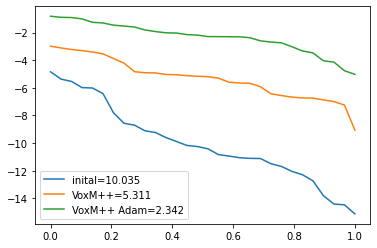

In [11]:
plt.plot(torch.linspace(0,1,30),-torch.sort(tre_net[0])[0],label='inital='+'%0.3f'%(tre_net[0].mean()))
plt.plot(torch.linspace(0,1,30),-torch.sort(tre_net[1])[0],label='VoxM++='+'%0.3f'%(tre_net[1].mean()))
plt.plot(torch.linspace(0,1,30),-torch.sort(tre_net[2])[0],label='VoxM++ Adam='+'%0.3f'%(tre_net[2].mean()))
plt.legend()
plt.show()



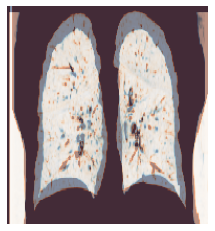

/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:4065: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


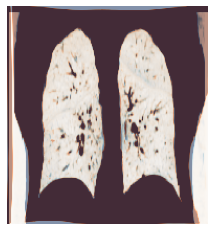

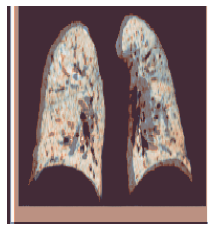

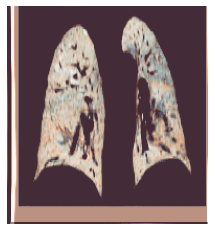

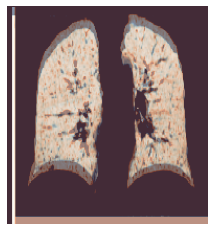

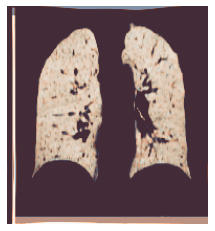

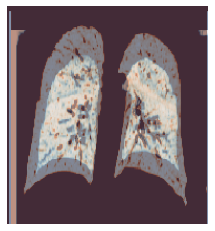

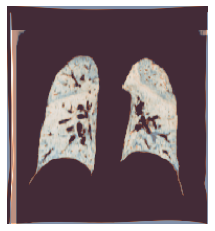

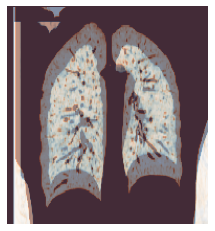

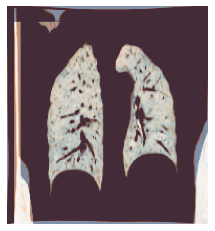

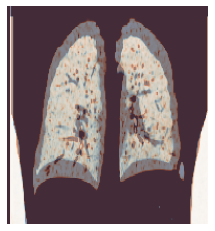

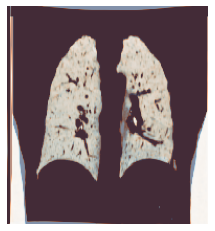

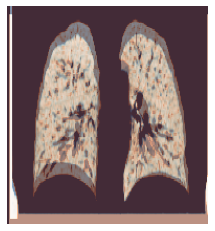

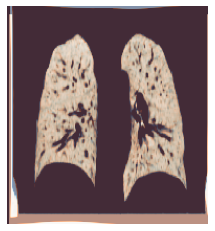

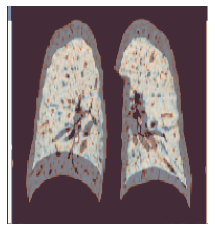

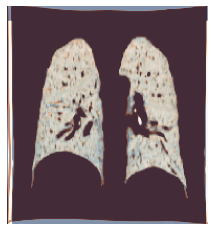

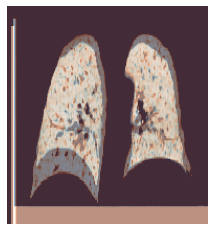

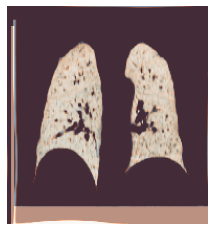

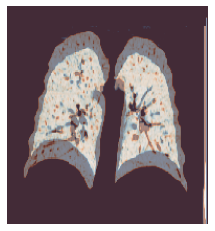

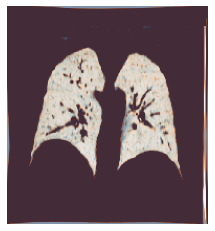

In [12]:
for i in range(10):
    
    plt.imshow(torch.clamp(img_all_fix[i+8,0,:,110],0,700).div(700).pow(1.25).t().flip(0),'Blues')
    plt.imshow(torch.clamp(img_all_mov[i+8,0,:,110],0,500).div(500).pow(1.25).t().flip(0),'Oranges',alpha=.5)
    plt.axis('off')
    plt.savefig('l2r_lung_ct/copd_'+str(i+1)+'_before.png')
    plt.show()
    
    warped = F.grid_sample(img_all_mov[i+8:i+9],disp_copd[i:i+1].permute(0,2,3,4,1)+F.affine_grid(torch.eye(3,4).unsqueeze(0),(1,1,H,W,D)))
    plt.imshow(torch.clamp(img_all_fix[i+8,0,:,110],0,700).div(700).pow(1.25).t().flip(0),'Blues')
    plt.imshow(torch.clamp(warped[0,0,:,110],0,500).div(500).pow(1.25).t().flip(0),'Oranges',alpha=.5)
    plt.axis('off')
    plt.savefig('l2r_lung_ct/copd_'+str(i+1)+'_before.png')
    plt.show()